SNU / Intro to Robotics 

#GridWorld Example PI/VI # 

> Importing Modules



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

> Making Environments

In [ ]:
# We are going to make 4 by 4 Grid World where agent starts moving at 0,0 and needs to arrive 3,3
# Each step, agent could go to 4 direction near to its block.
# There are termination hole at 2,1 where agent immediately recives -100 reward and terminates.
# Also, Collision with walls are -5, Goal zone gives +100 rewards
# Going to the goal or termination hole, agent terminates.

goal_pos = (3, 3)  # position of the goal
trap_pos = (2, 1) # position where trap exists 

value_PI = np.zeros((4,4)) #matrix where value function of each states are saved while using VI
value_VI = np.zeros((4,4)) #matrix where value function of each states are saved while using VI
value_PI_sto = np.zeros((4,4)) #matrix where value function of each states are saved while using PI under stochastic model
Rewards = np.zeros((4,4))
Rewards[goal_pos] = 100 
Rewards[trap_pos] = -100 # Rewards matrix is matrix with rewards given when arrived at such state. 
directions = ['Left','Up','Right','Down', 'Stay'] # Possible actions agent could choose (stay only when termination occur)
state = np.array([0,0]) 
action = {'Up' : np.array([-1,0]), 'Down':np.array([1,0]), 'Right':np.array([0,1]), 'Left' : np.array([0,-1]), 'Stay' : np.array([0,0]) } #possible actions 
policy_PI = [['Right','Up','Left','Down'],['Right','Up','Left','Down'],['Right','Stay','Left','Down'],['Right','Up','Left','Stay']] # Random Initial Policy
policy_PI_sto = [['Right','Up','Left','Down'],['Right','Up','Left','Down'],['Right','Stay','Left','Down'],['Right','Up','Left','Stay']]
#you can call values / Rewards using command : value[tuple(state)]

#parameters for training PI 
gamma = 0.9
num_improve = 10
num_eval_per_improve = 30

#parameters for training VI
gamma = gamma
num_value_iteration = 1000

def update_state(state, direction):
  #Returns Updated state, considering collision with walls / Return new state & whether collision had occured
  if np.array_equal(state, goal_pos) or np.array_equal(state, trap_pos):
    return state, False
  else:
    state_prime = state + action[direction]
    if(0<=state_prime[0]<4) and (0<=state_prime[1]<4):
      return state_prime , False
    else: 
      return state, True


Function Visualizing Policy

In [ ]:
#Function to plot policy with arrows (directions)
def plot_arrows(policy):
    fig, ax = plt.subplots(4, 4)
    for i in range(4):
        for j in range(4):
            if policy[i][j] == 'Up':
                ax[i, j].arrow(0, 0, 0, 0.5, head_width=0.2, head_length=0.2, fc='k', ec='k')
            elif policy[i][j] == 'Down':
                 ax[i, j].arrow(0, 0, 0, -0.5, head_width=0.2, head_length=0.2, fc='k', ec='k')
            elif policy[i][j] == 'Left':
                ax[i, j].arrow(0, 0, -0.5, 0, head_width=0.2, head_length=0.2, fc='k', ec='k')
            elif policy[i][j] == 'Right':
                ax[i, j].arrow(0, 0, 0.5, 0, head_width=0.2, head_length=0.2, fc='k', ec='k')

            ax[i, j].set_xlim([-1, 1])
            ax[i, j].set_ylim([-1, 1])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    plt.show()


> Policy Evaluation

In [ ]:
#update the value function using current policy
def policy_eval(policy, value):
  new_value = np.zeros((4,4))
  for i in range(4):
    for j in range(4):
      s_prime , collision= update_state(np.array([i,j]), policy[i][j])
      if ((i,j)==trap_pos or (i,j)==goal_pos):
        new_value[i,j] = 0
      else:  
        new_value[i,j] = Rewards[tuple(s_prime)] + gamma*value[tuple(s_prime)]
        if collision:
          new_value[i,j] -= 5
  return new_value


> Policy Improvement

In [ ]:
# Select Action (Directions) Maximizing value function of each state
def policy_improve(value):
  new_policy = [[None, None, None, None],[None, None, None, None],[None, None, None, None],[None, None, None, None]]
  for i in range(4):
    for j in range(4):
      if((i,j)==trap_pos) or ((i,j)==goal_pos):
        new_policy[i][j] = 'Stay' #terminate
      else:
        dummy = -10000000 #dummy variable used when choosing optimal direction
        for direction in directions[:-1]:
          s_prime, c = update_state(np.array([i,j]),direction)
          exp = gamma*value[tuple(s_prime)]+Rewards[tuple(s_prime)]
          if c:
            exp -= 5
          dummy = max(exp, dummy)
          if dummy == exp:
            new_policy[i][j] = direction
  return new_policy


Policy Iteration 

total iterations: 300
[['Down', 'Down', 'Right', 'Down'], ['Right', 'Right', 'Right', 'Down'], ['Up', 'Stay', 'Right', 'Down'], ['Down', 'Right', 'Right', 'Stay']]


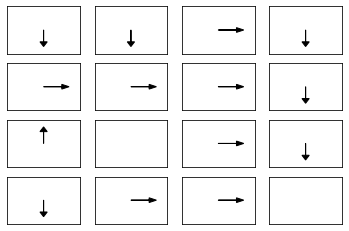

[[ -45.   -50.   -45.    81. ]
 [ -40.5  -45.   -40.5   90. ]
 [-100.     0.  -100.   100. ]
 [ -90.  -100.   -90.     0. ]]


In [ ]:
for i in range(num_improve):
  for j in range(num_eval_per_improve):
    new_value_PI = policy_eval(policy_PI, value_PI)
    value_PI = new_value_PI
policy_PI = policy_improve(value_PI)
print('total iterations:', num_improve*num_eval_per_improve)
print(policy_PI)
plot_arrows(policy_PI)
print(value_PI)

  
 

Value Iteration

In [ ]:
def update_value(value):
  # proceed one step of value iteration to update value function, and also return corresponding policy (action choosed to update value function)
  new_value = np.zeros((4,4))
  opt_policy = [[None,None,None,None],[None,None,None,None],[None,None,None,None],[None,None,None,None]]
  for i in range(4):
    for j in range(4):
      if((i,j)==trap_pos) or ((i,j)==goal_pos):
        opt_policy[i][j] = 'Stay' #terminate
        new_value[i,j] = 0
      else:
        dummy = -10000000 #dummy variable used when choosing optimal direction
        for direction in directions[:-1]:
          s_prime, c = update_state(np.array([i,j]),direction)
          exp = gamma*value[tuple(s_prime)]+Rewards[tuple(s_prime)]
          if c:
            exp -= 5
          dummy = max(dummy, exp)
          if dummy == exp:
            opt_policy[i][j] = direction
            new_value[i,j] = exp
            
  return new_value, opt_policy

total iterations: 1000
[['Down', 'Down', 'Down', 'Down'], ['Down', 'Right', 'Down', 'Down'], ['Down', 'Stay', 'Down', 'Down'], ['Right', 'Right', 'Right', 'Stay']]


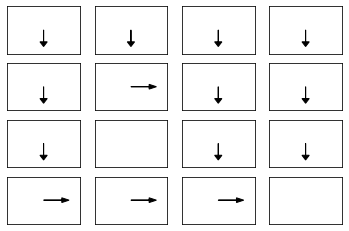

[[ 59.049  65.61   72.9    81.   ]
 [ 65.61   72.9    81.     90.   ]
 [ 72.9     0.     90.    100.   ]
 [ 81.     90.    100.      0.   ]]


In [ ]:
#Select action maximizing bellman optimal equation.
for i in range(num_value_iteration): 
  new_value_VI , policy_VI = update_value(value_VI)
  value_VI = new_value_VI

print('total iterations:', num_value_iteration)
print(policy_VI)
plot_arrows(policy_VI)
print(value_VI)

Comparing rate of convergence between PI and VI

Good! Now you succeed at implemeting PI/VI under deterministic model Situation. Now, look back at question 2 of handout print and consider stochastic model situation, which has 5% of noise distribution of going toward random directions. So, 85% of following command & 5%s of noise toward each random directions. (Extra Point Question from Now)

In [ ]:
#In here you need to make a state update model with stochastic probabilities, of 0.85/0.05/0.05/0.05.
#We are not actually gonna use this model for our policy evaluation / improvement fuction since we know the model. (Model-Based Algorithm)
import random

def update_state_stochastic(state, direction):
  #Returns Updated state, considering collision with walls / Return new state & whether collision had occured
  if np.array_equal(state,goal_pos) or np.array_equal(state,trap_pos):
    return state, False
  else:
    mask = random.random() #Generating arbitrary random # between 0~1
    if mask <0.8:
      direction_noise = direction
    else:
      direction_noise = random.choice(directions[:-1])
    state_prime = state + action[direction_noise]
    if(0<=state_prime[0]<4) and (0<=state_prime[1]<4):
      return state_prime , False
    else: 
      return state, True

Now, try updating policy gradient algorithm considering 

In [ ]:
#update the value function using current policy
def policy_eval_stochastic(policy, value):
  new_value = np.zeros((4,4))
  for i in range(4):
    for j in range(4):
      s_prime , collision = update_state(np.array([i,j]), policy[i][j])
      if (i,j) == trap_pos or (i,j)==goal_pos :
        new_value[i,j] = 0
      else:  
        new_value[i,j] = 0.8*(Rewards[tuple(s_prime)] + gamma*value[tuple(s_prime)])
        if collision:
          new_value[i,j] -= 5*0.8
        for direction in directions[:-1]:
          s_p, c= update_state(np.array([i,j]),direction)
          new_value[i,j] += 0.05*(Rewards[tuple(s_p)]+gamma*value[tuple(s_p)])
          if c:
            new_value[i,j] -= 0.05*5
  return new_value

# Select Action (Directions) Maximizing value function of each state
def policy_improve_stochastic(value):
  #you actually dont need to update this function because, argmax under deterministic situation isn't different from under stochastic situation!
  #if this isn't understandable, feel free to ask TA!
  new_policy = [[None, None, None, None],[None, None, None, None],[None, None, None, None],[None, None, None, None]]
  for i in range(4):
    for j in range(4):
      if((i,j)==trap_pos) or ((i,j)==goal_pos):
        new_policy[i][j] = 'Stay' #terminate
      else:
        dummy = -10000000
        for direction in directions[:-1]:
          s_prime, c = update_state(np.array([i,j]),direction)
          exp = gamma*value[tuple(s_prime)]+Rewards[tuple(s_prime)]
          if c:
            exp -= 5
          dummy = max(dummy, exp)
          if dummy == exp:
            new_policy[i][j] = direction
  return new_policy

Now execute policy iteration

total iterations: 300
[['Right', 'Right', 'Right', 'Down'], ['Right', 'Right', 'Right', 'Down'], ['Down', 'Stay', 'Right', 'Down'], ['Right', 'Right', 'Right', 'Stay']]


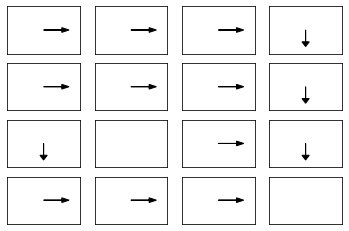

[[49.09765351 56.18855706 64.31912324 73.02814087]
 [48.76930104 55.47885124 72.88333023 83.740193  ]
 [48.31037516  0.         76.24830519 96.28218054]
 [64.30299311 74.30295013 95.83749371  0.        ]]


In [ ]:
for i in range(num_improve):
  for j in range(num_eval_per_improve):
    new_value_PI = policy_eval_stochastic(policy_PI_sto, value_PI_sto)
    value_PI_sto = new_value_PI
  policy_PI_sto = policy_improve_stochastic(value_PI_sto)
print('total iterations:', num_improve*num_eval_per_improve)
print(policy_PI_sto)
plot_arrows(policy_PI_sto)
print(value_PI_sto)

Visuallize your policy iteration under deterministic / stochastic model!

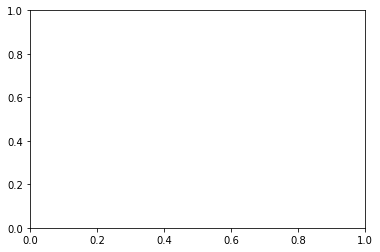

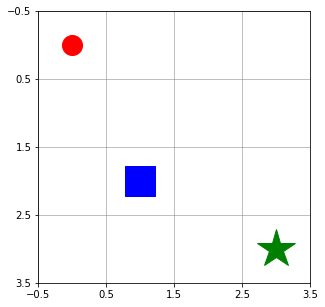

In [ ]:
robot_pos = np.array((0, 0))  # starting position of the robot

fig, ax = plt.subplots()
policy = policy_PI_sto # choose from policy_PI, policy_VI, policy_PI_sto
model = update_state_stochastic # choose from update_state & update_state_stochastic

def animate(i):
    global robot_pos
    if i == 0:
        robot_pos = np.array((0, 0))  # starting position of the robot
    ax.clear()
    plt.cla()
    plt.xlim(-0.5, 3.5)
    plt.ylim( 3.5, - 0.5)
    plt.xticks([-0.5, 0.5, 1.5, 2.5, 3.5])
    plt.yticks([-0.5, 0.5, 1.5, 2.5, 3.5])
    plt.gca().set_aspect('equal', adjustable='box')  
    plt.plot(robot_pos[1], robot_pos[0], 'ro', markersize=20)
    plt.plot(goal_pos[1], goal_pos[0], 'g*', markersize=40)
    plt.plot(trap_pos[1], trap_pos[0], 'bs', markersize=30)
    
    robot_pos, c= model(robot_pos, policy[robot_pos[0]][robot_pos[1]])

    plt.grid(True, linewidth=0.5, color='gray')

#Create the animation
fig = plt.figure(figsize=(5, 5))
anim = FuncAnimation(fig, animate, frames=range(7), interval=100)
HTML(anim.to_jshtml())